<h1>Introduction </h1>
Proyek Akhir CascadePEOW

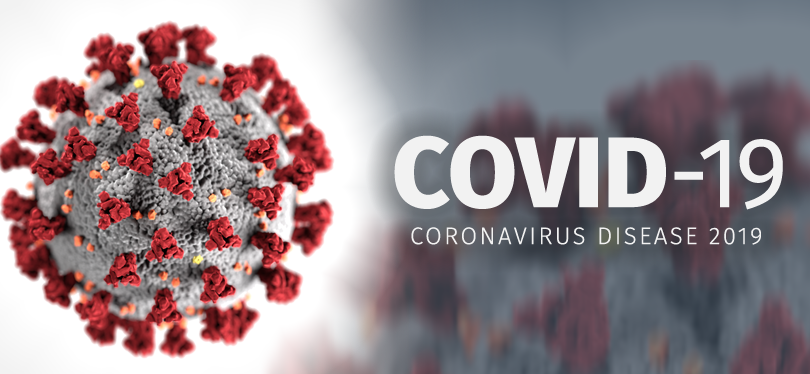

Novel Coronavirus 2019 (nCoV-2019) is a virus which affects respiratory system and was first discovered in Wuhan, China. Some early reports suggested that virus may have been transmitted from animal to person. As we know whole world has been shutdown because of the widespread cases. At this time it's unclear how easily or sustainably this virus is spreading between people.

IDE :
membuat model yang dapat memprediksi situasi positif aktif harian covid selama 1 bulan kedepan

Deskripsi :
menggunakan data-data yang ada, membuat dan memilih feature yang paling berdampak untuk memodelkan situasi pandemi covid dengan output (y) adalah positif aktif harian covid. 

#<h3> Getting the data </h3>

All Dataset : https://drive.google.com/drive/folders/1c02YJCWh21x5qKxs8vAMQiQalZXPPrAb?usp=sharing <br>                          
- Mobility Data (Apple) : https://covid19.apple.com/mobility
- Mobility Data (Google): https://www.google.com/covid19/mobility/ 
- Vaksinasi             : https://vaksin.kemkes.go.id/#/vaccines 
- Positif Aktif : https://sinta.ristekbrin.go.id/covid/datasets
- Positif Harian : https://sinta.ristekbrin.go.id/covid/datasets
- Isolasi Mandiri & Vaksinasi jakarta : https://tiny.cc/Datacovidjakarta

In [ ]:
pip install plotly

In [116]:
# import library 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import ParameterSampler

import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#<h2>Preprocessing</h2>


### Mobility Data (Apple) -> Indonesia
Date : 2020-01-13 to 2021-08-23


In [ ]:
# df_apple_mobility = pd.read_csv('/content/drive/MyDrive/Projects/Dataset/mobility_apple.csv')
df_apple_mobility = pd.read_csv('/content/drive/MyDrive/Data Science Study/Projects/Dataset/mobility_apple.csv')
df_apple_mobility.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,...,2021-07-15,2021-07-16,2021-07-17,2021-07-18,2021-07-19,2021-07-20,2021-07-21,2021-07-22,2021-07-23,2021-07-24,2021-07-25,2021-07-26,2021-07-27,2021-07-28,2021-07-29,2021-07-30,2021-07-31,2021-08-01,2021-08-02,2021-08-03,2021-08-04,2021-08-05,2021-08-06,2021-08-07,2021-08-08,2021-08-09,2021-08-10,2021-08-11,2021-08-12,2021-08-13,2021-08-14,2021-08-15,2021-08-16,2021-08-17,2021-08-18,2021-08-19,2021-08-20,2021-08-21,2021-08-22,2021-08-23
0,country/region,Albania,driving,NaN,NaN,NaN,100.0,95.30,101.43,97.20,103.55,112.67,104.83,94.39,94.07,93.51,92.94,102.13,102.38,101.41,94.62,89.12,90.17,90.21,97.71,102.50,108.92,92.82,91.48,93.99,96.72,102.46,103.29,107.83,87.99,94.18,94.62,99.70,139.30,123.90,...,250.37,271.72,268.21,263.83,243.24,251.90,278.22,297.08,315.51,330.00,349.02,330.53,315.20,318.61,320.01,347.67,379.06,385.03,369.97,359.48,367.48,397.45,409.22,424.75,408.65,445.31,432.02,425.92,427.53,445.61,440.19,429.67,445.62,423.46,408.55,411.35,423.65,404.54,391.96,369.88
1,country/region,Albania,walking,NaN,NaN,NaN,100.0,100.68,98.93,98.46,100.85,100.13,82.13,95.65,97.78,95.39,94.24,93.73,97.06,77.27,83.37,82.73,84.39,88.19,90.79,88.70,79.32,87.12,88.06,99.40,85.84,94.63,99.74,81.41,90.19,90.45,94.16,95.69,109.21,108.40,...,236.29,244.01,234.80,202.00,223.75,226.65,260.72,265.93,284.18,273.39,253.82,291.86,270.02,276.76,269.64,285.67,295.10,281.36,321.45,305.67,315.95,322.90,357.65,336.55,316.97,359.91,362.22,373.30,361.54,355.05,355.78,318.93,379.10,368.40,360.98,363.16,364.09,342.81,296.97,334.54
2,country/region,Argentina,driving,NaN,NaN,NaN,100.0,97.07,102.45,111.21,118.45,124.01,95.44,95.13,95.42,97.66,99.42,113.34,118.23,91.31,93.37,91.12,92.35,96.74,111.24,123.96,89.01,91.66,89.18,94.49,95.98,111.12,121.53,89.23,96.42,96.97,101.68,104.90,122.91,127.62,...,87.62,110.41,119.97,76.00,84.39,104.62,87.91,95.23,116.22,122.68,75.03,79.49,81.46,83.51,87.12,107.44,121.10,76.60,69.50,73.32,75.93,79.32,107.97,130.56,60.93,67.70,72.97,77.70,83.78,115.24,137.72,103.02,83.04,74.66,79.03,79.81,105.67,124.29,78.22,70.24
3,country/region,Argentina,walking,NaN,NaN,NaN,100.0,95.11,101.37,112.67,116.72,114.14,84.54,101.37,106.12,104.91,102.56,104.88,98.83,73.64,94.27,93.86,92.20,96.00,98.99,97.42,67.21,95.18,96.25,100.39,99.10,105.00,106.45,73.12,104.20,105.87,111.47,113.20,128.75,103.47,...,75.18,89.34,90.67,50.82,73.40,92.07,75.92,82.94,100.50,90.21,52.75,70.94,71.21,70.80,76.64,89.37,92.05,53.20,64.84,70.74,68.89,70.38,93.11,100.36,39.50,59.79,67.47,69.68,74.27,93.41,109.55,74.71,59.85,70.33,73.13,72.57,95.44,95.20,56.09,65.87
4,country/region,Australia,driving,AU,NaN,NaN,100.0,102.98,104.21,108.63,109.08,89.00,99.35,103.53,106.80,107.40,115.65,109.66,88.59,85.18,95.91,99.40,99.92,103.04,103.73,85.73,93.39,95.83,98.63,102.40,107.46,106.55,86.33,98.78,100.08,103.28,106.19,116.62,115.36,93.51,...,96.91,82.88,67.98,79.44,78.88,78.63,80.76,84.23,76.98,61.62,72.95,76.87,89.22,93.40,98.98,97.09,70.08,80.33,82.22,85.13,86.43,78.32,66.63,55.40,75.12,78.55,80.66,83.20,87.03,83.47,68.26,77.28,77.72,79.80,81.58,86.38,78.02,63.23,74.92,75.37


In [ ]:
df_apple_mobility.isnull().sum()

geo_type                  0
region                    0
transportation_type       0
alternative_name       3647
sub-region             1362
                       ... 
2021-08-19               39
2021-08-20               39
2021-08-21               39
2021-08-22               39
2021-08-23               39
Length: 595, dtype: int64

In [ ]:
df_apple_mobility.drop(labels=['geo_type', 'alternative_name', 'sub-region', 'country'], axis=1, inplace=True)

In [ ]:
df_apple_mobility.drop(df_apple_mobility.index[df_apple_mobility['transportation_type'] == 'transit'], inplace = True)

In [ ]:
df_apple_mobility.isnull().sum()

region                  0
transportation_type     0
2020-01-13             39
2020-01-14             39
2020-01-15             39
                       ..
2021-08-19             39
2021-08-20             39
2021-08-21             39
2021-08-22             39
2021-08-23             39
Length: 591, dtype: int64

In [ ]:
df_apple_mobility = df_apple_mobility.melt(id_vars=["region", "transportation_type"], 
        var_name="Date", 
        value_name="Value")

In [ ]:
df_apple_mobility.isnull().sum()

region                     0
transportation_type        0
Date                       0
Value                  33800
dtype: int64

In [ ]:
df_apple_mobility.dropna(inplace=True)

df_apple_mobility.isna().sum()

region                 0
transportation_type    0
Date                   0
Value                  0
dtype: int64

In [ ]:
df_apple_mobility

,region,transportation_type,Date,Value
0,Albania,driving,2020-01-13,100.00
1,Albania,walking,2020-01-13,100.00
2,Argentina,driving,2020-01-13,100.00
3,Argentina,walking,2020-01-13,100.00
4,Australia,driving,2020-01-13,100.00
...,...,...,...,...
2438455,York County,walking,2021-08-23,218.29
2438456,Young County,driving,2021-08-23,151.22
2438457,Yuba County,driving,2021-08-23,151.37
2438458,Yuma County,driving,2021-08-23,118.54


In [ ]:
df_indonesia = df_apple_mobility[df_apple_mobility.region == 'Indonesia']
df_cleaned_indonesia_mobility = df_indonesia
df_cleaned_indonesia_mobility

,region,transportation_type,Date,Value
48,Indonesia,driving,2020-01-13,100.00
49,Indonesia,walking,2020-01-13,100.00
4188,Indonesia,driving,2020-01-14,100.95
4189,Indonesia,walking,2020-01-14,100.61
8328,Indonesia,driving,2020-01-15,103.17
...,...,...,...,...
2426089,Indonesia,walking,2021-08-21,91.70
2430228,Indonesia,driving,2021-08-22,99.71
2430229,Indonesia,walking,2021-08-22,76.76
2434368,Indonesia,driving,2021-08-23,91.03


In [ ]:
df_cleaned_indonesia_mobility.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1172 entries, 48 to 2434369
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   region               1172 non-null   object 
 1   transportation_type  1172 non-null   object 
 2   Date                 1172 non-null   object 
 3   Value                1172 non-null   float64
dtypes: float64(1), object(3)
memory usage: 45.8+ KB


In [ ]:
df_cleaned_indonesia_mobility['Date'] = pd.to_datetime(df_cleaned_indonesia_mobility['Date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


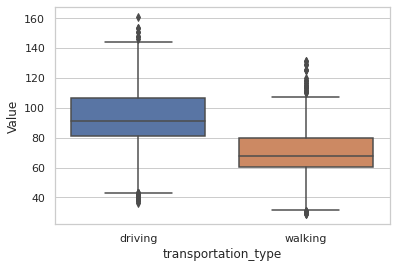

In [ ]:
sns.set(style='whitegrid')
 
sns.boxplot(x="transportation_type",
                y="Value",
                data=df_cleaned_indonesia_mobility)

In [ ]:
df_cleaned_indonesia_mobility.set_index('Date', inplace = True)

In [ ]:
df_cleaned_indonesia_mobility.head()

,region,transportation_type,Value
Date,,,
2020-01-13,Indonesia,driving,100.00
2020-01-13,Indonesia,walking,100.00
2020-01-14,Indonesia,driving,100.95
2020-01-14,Indonesia,walking,100.61
2020-01-15,Indonesia,driving,103.17


In [ ]:
# df_cleaned_indonesia_mobility.to_csv('/content/drive/MyDrive/Projects/Dataset/cleaned_apple_indonesia_mobility.csv', index = False)

##<h3>Vaksinasi -> Indonesia</h3>
Date : 2021-07-04 to 2021-06-24	

In [ ]:
df_vaksinasi = pd.read_csv('/content/drive/MyDrive/Data Science Study/Projects/Dataset/Jumlah_Divaksin_Pertama_Nasional_data_monitor__data.csv')
df_vaksinasi = df_vaksinasi[['Provinsi','Kategori','Region','Tanggal','Divaksin','Divaksin 1','Divaksin 2']]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,11,12,13,14,15,16,17,18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_vaksinasi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841089 entries, 0 to 841088
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Provinsi    841089 non-null  object
 1   Kategori    841089 non-null  object
 2   Region      841089 non-null  object
 3   Tanggal     841089 non-null  object
 4   Divaksin    841089 non-null  int64 
 5   Divaksin 1  841089 non-null  int64 
 6   Divaksin 2  841089 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 44.9+ MB


In [ ]:
df_vaksinasi.rename(columns={'Divaksin 1':'vaksin_1',
                             'Divaksin 2':'vaksin_2',
                             'Divaksin':'total_vaksin'},inplace=True)

In [ ]:
# rename labels on Province 
df_vaksinasi.rename({'Jawa Tengah':'Central Java',
                                  'Kalimantan Tengah':'Central Kalimantan',
                                  'Sulawesi Tengah':'Central Sulawesi',
                                  'Jawa Timur':'East Java',
                                  'Kalimantan Timur':'East Kalimantan',
                                  'Nusa Tenggara Timur':'East Nusa Tenggara',
                                  'Kalimantan Utara':'North Kalimantan',
                                  'Maluku Utara':'North maluku',
                                  'Sulawesi Utara':'North Sulawesi',
                                  'Sumatra Utara':'North Sumatra',
                                  'Kalimantan Selatan':'South Kalimantan',
                                  'Sulawesi Selatan':'South Sulawesi',
                                  'Sumatra Selatan':'South Sumatra',
                                  'Jawa Barat':'West Java',
                                  'Kalimantan Barat':'West Kalimantan',
                                  'Nusa Tenggara Barat':'West Nusa Tenggara',
                                  'Papua Barat':'West Papua',
                                  'Sulawesi Barat':'West Sulawesi',
                                  'Sumatra Barat':'West Sumatra',  
                                  'Kepulauan Bangka Belitung' : 'Bangka Belitung Islands',
                                  'Yogyakarta' : 'Special Region of Yogyakarta',
                                  'Kepulauan Riau' : 'Riau Islands',
                                  'Sulawesi Tenggara' : 'South East Sulawesi',
                     'DKI Jakarta':'Jakarta'},inplace=True)

In [ ]:
df_vaksinasi[df_vaksinasi['Provinsi']=='DKI JAKARTA'].shape

(57, 7)

In [ ]:
df_vaksinasi[df_vaksinasi['Provinsi']=='DKI Jakarta'].shape

(27067, 7)

In [ ]:
df_vaksinasi['Provinsi']=df_vaksinasi['Provinsi'].str.replace('DKI JAKARTA','DKI Jakarta')

In [ ]:
df_vaksinasi['Provinsi'].unique()

array(['Aceh', 'Jawa Barat', 'Banten', 'DKI Jakarta', 'Sulawesi Barat',
       'Bali', 'Jambi', 'Jawa Timur', 'Sulawesi Selatan', 'Maluku Utara',
       'Nusa Tenggara Barat', 'Nusa Tenggara Timur', 'Papua',
       'Papua Barat', 'Lampung', 'Maluku', 'Riau', 'Sumatera Utara',
       'Kalimantan Selatan', 'Kalimantan Tengah', 'Sumatera Selatan',
       'Jawa Tengah', 'Kalimantan Barat', 'Sulawesi Utara',
       'Sumatera Barat', 'Kalimantan Timur', 'Kepulauan Riau',
       'Yogyakarta', 'Sulawesi Tengah', 'Bengkulu', 'Sulawesi Tenggara',
       'Kalimantan Utara', 'Kepulauan Bangka Belitung', 'Gorontalo'],
      dtype=object)

In [ ]:
df_vaksinasi.set_index('Tanggal', inplace = True)

In [ ]:
df_vaksinasi.head()

,Provinsi,Kategori,Region,total_vaksin,vaksin_1,vaksin_2
Tanggal,,,,,,
7/4/2021,Aceh,Menunggu Konfirmasi,Sumatera,116,115,1
7/4/2021,Aceh,Menunggu Konfirmasi,Sumatera,14,14,0
7/4/2021,Aceh,Menunggu Konfirmasi,Sumatera,66,66,0
7/4/2021,Aceh,Menunggu Konfirmasi,Sumatera,26,26,0
7/4/2021,Aceh,Menunggu Konfirmasi,Sumatera,58,58,0


In [ ]:
# visualize on google data studio


In [ ]:
df_vaksinasi_jakarta = df_vaksinasi[df_vaksinasi['Provinsi'] == 'DKI JAKARTA']
df_vaksinasi_jakarta.head()

,Provinsi,Kategori,Region,total_vaksin,vaksin_1,vaksin_2
Tanggal,,,,,,


## <h3>Mobility Data (Google) -> Indonesia & Jakarta</h3>
Date : 2021-01-01 to 2021-08-17


In [ ]:
mobility_indonesia = pd.read_csv('/content/drive/MyDrive/Data Science Study/Projects/Dataset/2021_ID_Region_Mobility_Report.csv')
mobility_indonesia.sample(10)

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
3065,ID,Indonesia,Jakarta,NaN,NaN,ID-JK,NaN,ChIJnUvjRenzaS4RILjULejFAAE,2021-03-30,-26,-5,-45,-36.0,-32,9
80,ID,Indonesia,NaN,NaN,NaN,NaN,NaN,ChIJtwRkSdcHTCwRhfStG-dNe-M,2021-03-22,-17,1,-17,-32.0,-25,6
549,ID,Indonesia,Bali,NaN,NaN,ID-BA,NaN,ChIJoQ8Q6NNB0S0RkOYkS7EPkSQ,2021-04-02,-33,-20,-31,-62.0,-57,11
501,ID,Indonesia,Bali,NaN,NaN,ID-BA,NaN,ChIJoQ8Q6NNB0S0RkOYkS7EPkSQ,2021-02-13,-46,-36,-59,-71.0,-44,10
726,ID,Indonesia,Bangka Belitung Islands,NaN,NaN,ID-BB,NaN,ChIJizmlLUMWFy4RuSOEsf04fhI,2021-02-09,-22,-8,-27,-24.0,-33,0
2932,ID,Indonesia,Gorontalo,NaN,NaN,ID-GO,NaN,ChIJSa0hzCXAcTIRIBr3yvsLAwE,2021-07-04,29,47,33,14.0,-1,1
7094,ID,Indonesia,West Kalimantan,NaN,NaN,ID-KB,NaN,ChIJu_7rjBcYBS4RoEghTO3sXM0,2021-08-13,-21,2,-39,-38.0,-22,3
6514,ID,Indonesia,Special Region of Yogyakarta,NaN,NaN,ID-YO,NaN,ChIJxWtbvYdXei4R8LPIyrKSG20,2021-04-13,-29,-9,-42,-48.0,-37,14
1383,ID,Indonesia,Central Java,NaN,NaN,ID-JT,NaN,ChIJ3RjVnJt1ZS4RRrztj53Rd8M,2021-01-10,-16,-3,-22,-32.0,-5,10
3587,ID,Indonesia,Lampung,NaN,NaN,ID-LA,NaN,ChIJpyKsUwF2Oy4RmrCJX8dYO48,2021-06-02,5,35,13,4.0,-25,7


In [ ]:
mobility_indonesia.isnull().sum()

country_region_code                                      0
country_region                                           0
sub_region_1                                           229
sub_region_2                                          8015
metro_area                                            8015
iso_3166_2_code                                        229
census_fips_code                                      8015
place_id                                                 0
date                                                     0
retail_and_recreation_percent_change_from_baseline       0
grocery_and_pharmacy_percent_change_from_baseline        0
parks_percent_change_from_baseline                       0
transit_stations_percent_change_from_baseline          142
workplaces_percent_change_from_baseline                  0
residential_percent_change_from_baseline                 0
dtype: int64

In [ ]:
mobility_indonesia.drop(labels=['iso_3166_2_code','sub_region_2',
                                'metro_area','census_fips_code',
                                'place_id','country_region_code',
                                'country_region'],axis=1, inplace=True)
mobility_indonesia.isnull().sum()

sub_region_1                                          229
date                                                    0
retail_and_recreation_percent_change_from_baseline      0
grocery_and_pharmacy_percent_change_from_baseline       0
parks_percent_change_from_baseline                      0
transit_stations_percent_change_from_baseline         142
workplaces_percent_change_from_baseline                 0
residential_percent_change_from_baseline                0
dtype: int64

In [ ]:
mobility_indonesia.rename(columns={'sub_region_1':'province',
                            'retail_and_recreation_percent_change_from_baseline':'retail_and_recreation',
                            'grocery_and_pharmacy_percent_change_from_baseline':'grocery_and_pharmacy',
                            'parks_percent_change_from_baseline':'parks',
                            'transit_stations_percent_change_from_baseline':'transit_stations',
                            'workplaces_percent_change_from_baseline':'workplaces',
                            'residential_percent_change_from_baseline':'residental'},inplace=True)

In [ ]:
# drop rows that have no province identification
mobility_indonesia = mobility_indonesia[mobility_indonesia['province'].isnull() == False]
mobility_indonesia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7786 entries, 229 to 8014
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   province               7786 non-null   object 
 1   date                   7786 non-null   object 
 2   retail_and_recreation  7786 non-null   int64  
 3   grocery_and_pharmacy   7786 non-null   int64  
 4   parks                  7786 non-null   int64  
 5   transit_stations       7644 non-null   float64
 6   workplaces             7786 non-null   int64  
 7   residental             7786 non-null   int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 547.5+ KB


In [ ]:
mobility_indonesia.describe(include='object')

,province,date
count,7786,7786
unique,34,229
top,Maluku,2021-03-25
freq,229,34


In [ ]:
mobility_indonesia.isna().sum()

province                   0
date                       0
retail_and_recreation      0
grocery_and_pharmacy       0
parks                      0
transit_stations         142
workplaces                 0
residental                 0
dtype: int64

In [ ]:
mobility_indonesia.describe().T

,count,mean,std,min,25%,50%,75%,max
retail_and_recreation,7786.0,-11.166838,13.723222,-92.0,-20.0,-12.0,-3.0,60.0
grocery_and_pharmacy,7786.0,13.263422,19.646022,-93.0,0.0,12.0,26.0,155.0
parks,7786.0,-9.558438,20.952851,-87.0,-22.0,-10.0,3.0,89.0
transit_stations,7644.0,-26.235871,20.356002,-98.0,-38.0,-28.0,-15.0,58.0
workplaces,7786.0,-25.743514,12.204534,-85.0,-30.0,-25.0,-19.0,8.0
residental,7786.0,3.083740,6.213349,-18.0,-1.0,3.0,7.0,36.0


In [ ]:
# Impute missing value for transit station
  # use median depends on the statistical value from above
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
imputer.fit(mobility_indonesia[['transit_stations']])

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [ ]:
mobility_indonesia[['transit_stations']] = imputer.transform(mobility_indonesia[['transit_stations']])
mobility_indonesia['transit_stations'].isna().sum()

0

In [ ]:
mobility_indonesia.set_index('date', inplace = True)

In [ ]:
mobility_indonesia.head()

,province,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residental
date,,,,,,,
2021-01-01,Aceh,-11,6,20,-4.0,-54,6
2021-01-02,Aceh,-8,9,10,1.0,-33,2
2021-01-03,Aceh,-7,6,-5,9.0,-15,1
2021-01-04,Aceh,-8,10,-8,-8.0,-16,0
2021-01-05,Aceh,-8,11,-8,-10.0,-17,0


In [ ]:
mobility_indonesia_jakarta = mobility_indonesia[mobility_indonesia['province']=='Jakarta']

In [ ]:
mobility_indonesia_jakarta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229 entries, 2021-01-01 to 2021-08-17
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   province               229 non-null    object 
 1   retail_and_recreation  229 non-null    int64  
 2   grocery_and_pharmacy   229 non-null    int64  
 3   parks                  229 non-null    int64  
 4   transit_stations       229 non-null    float64
 5   workplaces             229 non-null    int64  
 6   residental             229 non-null    int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 14.3+ KB


In [ ]:
mobility_indonesia_jakarta.to_csv('/content/drive/MyDrive/Data Science Study/Projects/Dataset/mobility_indonesia_jakarta_preprocessed.csv')

In [ ]:
mobility_indonesia.to_csv('/content/drive/MyDrive/Data Science Study/Projects/Dataset/mobility_indonesia_preprocessed.csv')

## <h3>Positif Harian -> Indonesia</h3>
Date : 2020-03-15 to 2021-08-27

In [ ]:
positif_harian = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/positif_harian.xlsx')
positif_harian.rename(columns={positif_harian.columns[0] : "Tanggal"}, inplace = True)
positif_harian.set_index('Tanggal', inplace = True)
positif_harian.head()

FileNotFoundError: ignored

In [ ]:
positif_harian.isnull().sum()

NameError: ignored

In [ ]:
positif_harian.describe().T

,count,mean,std,min,25%,50%,75%,max
Aceh,428.0,74.242991,91.740734,1.0,11.00,34.5,103.00,459.0
Bali,514.0,205.011673,307.164102,1.0,47.25,101.0,197.00,1910.0
Banten,517.0,247.957447,546.760997,1.0,25.00,100.0,216.00,4016.0
Babel,423.0,108.947991,156.542280,1.0,8.00,55.0,130.00,862.0
Bengkulu,438.0,50.954338,81.292464,1.0,6.25,20.0,54.00,520.0
DIY,504.0,294.097222,503.065122,-1.0,18.00,135.5,261.25,2732.0
Jakarta,530.0,1601.992453,2326.832795,5.0,376.25,964.0,1632.50,14619.0
Jambi,410.0,67.590244,97.906187,1.0,14.00,34.0,71.75,567.0
Jabar,525.0,1309.367619,1897.641448,1.0,91.00,702.0,1468.00,11101.0
Jateng,524.0,891.043893,1211.876395,1.0,143.75,455.5,993.00,5655.0


In [ ]:
positif_harian.fillna(0, inplace = True)
positif_harian.isnull().sum()

Aceh         0
Bali         0
Banten       0
Babel        0
Bengkulu     0
DIY          0
Jakarta      0
Jambi        0
Jabar        0
Jateng       0
Jatim        0
Kalbar       0
Kaltim       0
Kalteng      0
Kalsel       0
Kaltara      0
Kep Riau     0
NTB          0
Sumsel       0
Sumbar       0
Sulut        0
Sumut        0
Sultra       0
Sulsel       0
Sulteng      0
Lampung      0
Riau         0
Malut        0
Maluku       0
Papbar       0
Papua        0
Sulbar       0
NTT          0
Gorontalo    0
dtype: int64

In [ ]:
positif_harian.describe().T

,count,mean,std,min,25%,50%,75%,max
Aceh,531.0,59.841808,87.430821,0.0,2.0,19.0,89.0,459.0
Bali,531.0,198.448211,304.349202,0.0,44.0,97.0,193.0,1910.0
Banten,531.0,241.419962,540.954819,0.0,22.0,91.0,212.5,4016.0
Babel,531.0,86.789077,146.419586,0.0,1.0,23.0,96.5,862.0
Bengkulu,531.0,42.030132,76.319457,0.0,2.0,13.0,43.0,520.0
DIY,531.0,279.143126,494.332126,-1.0,12.0,110.0,255.5,2732.0
Jakarta,531.0,1598.975518,2325.675941,0.0,374.5,964.0,1627.0,14619.0
Jambi,531.0,52.188324,90.567781,0.0,1.0,21.0,56.0,567.0
Jabar,531.0,1294.572505,1891.947681,0.0,83.0,683.0,1445.0,11101.0
Jateng,531.0,879.297552,1208.137088,0.0,139.5,443.0,985.0,5655.0


In [ ]:
positif_harian.loc[positif_harian['DIY'] < 0] = 0
positif_harian.describe()

,Aceh,Bali,Banten,Babel,Bengkulu,DIY,Jakarta,Jambi,Jabar,Jateng,Jatim,Kalbar,Kaltim,Kalteng,Kalsel,Kaltara,Kep Riau,NTB,Sumsel,Sumbar,Sulut,Sumut,Sultra,Sulsel,Sulteng,Lampung,Riau,Malut,Maluku,Papbar,Papua,Sulbar,NTT,Gorontalo
count,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000
mean,59.841808,198.442561,241.401130,86.789077,42.030132,279.145009,1598.966102,52.188324,1294.544256,879.297552,714.760829,66.421846,280.617702,80.657250,122.286252,59.047081,97.653484,47.984934,108.495292,161.824859,60.222222,176.583804,36.815443,195.041431,78.086629,86.438795,229.909605,21.838041,26.898305,41.691149,60.112994,21.414313,110.286252,20.856874
std,87.430821,304.352864,540.963064,146.419586,76.319457,494.331059,2325.682417,90.567781,1891.966934,1208.137088,1209.244975,119.717368,407.752643,92.513799,169.002794,110.716516,165.129819,74.110039,171.537810,200.014192,97.012329,330.512019,51.348787,250.491280,178.085839,131.997933,307.304642,42.536956,46.427149,75.093116,102.742756,41.357686,261.164874,37.005332
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,44.000000,22.000000,1.000000,2.000000,12.000000,374.500000,1.000000,83.000000,139.500000,239.000000,1.000000,31.500000,15.000000,34.000000,2.000000,4.500000,13.000000,35.000000,16.000000,6.000000,63.000000,3.000000,37.000000,1.000000,3.000000,11.000000,1.000000,1.000000,4.000000,6.500000,1.000000,0.000000,0.000000
50%,19.000000,97.000000,91.000000,23.000000,13.000000,110.000000,964.000000,21.000000,683.000000,443.000000,323.000000,22.000000,146.000000,55.000000,74.000000,12.000000,25.000000,23.000000,60.000000,100.000000,24.000000,86.000000,14.000000,100.000000,16.000000,48.000000,133.000000,7.000000,11.000000,16.000000,32.000000,4.000000,15.000000,6.000000
75%,89.000000,193.000000,212.500000,96.500000,43.000000,255.500000,1627.000000,56.000000,1445.000000,985.000000,686.000000,73.000000,319.000000,97.000000,123.500000,58.000000,98.000000,43.000000,101.500000,219.000000,65.500000,109.000000,57.000000,206.000000,56.000000,95.000000,296.500000,20.500000,32.000000,38.500000,70.500000,17.000000,91.500000,22.000000
max,459.000000,1910.000000,4016.000000,862.000000,520.000000,2732.000000,14619.000000,567.000000,11101.000000,5655.000000,8230.000000,779.000000,2364.000000,482.000000,958.000000,632.000000,928.000000,503.000000,1278.000000,1157.000000,708.000000,2045.000000,311.000000,1359.000000,1566.000000,717.000000,2205.000000,360.000000,349.000000,605.000000,1755.000000,241.000000,3598.000000,278.000000


In [ ]:
positif_harian.rename(columns = {'Jateng':'Central Java',
                                  'Kalteng':'Central Kalimantan',
                                  'Sulteng':'Central Sulawesi',
                                  'Jatim':'East Java',
                                  'Kaltim':'East Kalimantan',
                                  'NTT':'East Nusa Tenggara',
                                  'Kaltara':'North Kalimantan',
                                  'Malut':'North maluku',
                                  'Sulut':'North Sulawesi',
                                  'Sumut':'North Sumatra',
                                  'Kalsel':'South Kalimantan',
                                  'Sulsel':'South Sulawesi',
                                  'Sumsel':'South Sumatra',
                                  'Jabar':'West Java',
                                  'Kalbar':'West Kalimantan',
                                  'NTB':'West Nusa Tenggara',
                                  'Papbar':'West Papua',
                                  'Sulbar':'West Sulawesi',
                                  'Sumbar':'West Sumatra',   
                                  'Babel' : 'Bangka Belitung Islands',
                                  'DIY' : 'Special Region of Yogyakarta',
                                  'Kep  Riau' : 'Riau Islands',
                                  'Sultra' : 'South East Sulawesi'},inplace=True)

In [ ]:
positif_harian.head()

,Aceh,Bali,Banten,Bangka Belitung Islands,Bengkulu,Special Region of Yogyakarta,Jakarta,Jambi,West Java,Central Java,East Java,West Kalimantan,East Kalimantan,Central Kalimantan,South Kalimantan,North Kalimantan,Kep Riau,West Nusa Tenggara,South Sumatra,West Sumatra,North Sulawesi,North Sumatra,South East Sulawesi,South Sulawesi,Central Sulawesi,Lampung,Riau,North maluku,Maluku,West Papua,Papua,West Sulawesi,East Nusa Tenggara,Gorontalo
Tanggal,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-15,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-16,0.0,0.0,1.0,0.0,0.0,0.0,14.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-18,0.0,0.0,4.0,0.0,0.0,1.0,30.0,0.0,12.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-19,0.0,0.0,10.0,0.0,0.0,2.0,52.0,0.0,2.0,4.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
positif_harian_2021 = positif_harian.iloc[positif_harian.index >= '2021-01-01']
positif_harian_2021.tail()

,Aceh,Bali,Banten,Bangka Belitung Islands,Bengkulu,Special Region of Yogyakarta,Jakarta,Jambi,West Java,Central Java,East Java,West Kalimantan,East Kalimantan,Central Kalimantan,South Kalimantan,North Kalimantan,Kep Riau,West Nusa Tenggara,South Sumatra,West Sumatra,North Sulawesi,North Sumatra,South East Sulawesi,South Sulawesi,Central Sulawesi,Lampung,Riau,North maluku,Maluku,West Papua,Papua,West Sulawesi,East Nusa Tenggara,Gorontalo
Tanggal,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-08-23,229.0,434.0,124.0,191.0,55.0,507.0,485.0,62.0,1483.0,798.0,1073.0,182.0,487.0,179.0,297.0,181.0,82.0,155.0,278.0,80.0,58.0,514.0,70.0,179.0,331.0,250.0,357.0,73.0,10.0,23.0,101.0,14.0,223.0,39.0
2021-08-24,354.0,934.0,360.0,469.0,38.0,748.0,484.0,159.0,5255.0,1242.0,1700.0,283.0,791.0,227.0,519.0,242.0,120.0,198.0,273.0,390.0,183.0,1135.0,84.0,550.0,573.0,229.0,563.0,49.0,10.0,42.0,152.0,103.0,585.0,62.0
2021-08-25,368.0,746.0,355.0,388.0,75.0,873.0,789.0,274.0,5464.0,813.0,1619.0,339.0,865.0,186.0,466.0,284.0,84.0,202.0,167.0,380.0,243.0,1020.0,102.0,565.0,503.0,289.0,509.0,44.0,33.0,55.0,114.0,44.0,365.0,48.0
2021-08-26,361.0,565.0,239.0,345.0,91.0,795.0,577.0,161.0,5058.0,811.0,1351.0,317.0,637.0,168.0,473.0,208.0,136.0,143.0,210.0,483.0,203.0,975.0,57.0,448.0,471.0,204.0,555.0,55.0,8.0,136.0,150.0,65.0,383.0,60.0
2021-08-27,388.0,558.0,266.0,312.0,74.0,688.0,635.0,129.0,1349.0,1069.0,1409.0,267.0,523.0,182.0,253.0,367.0,114.0,191.0,156.0,316.0,129.0,1056.0,59.0,382.0,375.0,226.0,518.0,58.0,9.0,41.0,115.0,25.0,324.0,55.0


In [ ]:
positif_harian_2021.to_csv('/content/drive/MyDrive/Colab Notebooks/positif_harian_2021_preprocessed.csv')

## <h3>Positif Aktif Harian -> Indonesia
Date : 2020-03-21 to 2021-08-27

In [ ]:
positif_aktif_harian = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/positif_aktif_harian.xlsx')
positif_aktif_harian.rename(columns={positif_aktif_harian.columns[0] : "Tanggal"}, inplace = True)
positif_aktif_harian.set_index('Tanggal', inplace = True)
positif_aktif_harian.tail()

,Aceh,Bali,Banten,Babel,Bengkulu,DIY,Jakarta,Jambi,Jabar,Jateng,Jatim,Kalbar,Kaltim,Kalteng,Kalsel,Kaltara,Kep Riau,NTB,Sumsel,Sumbar,Sulut,Sumut,Sultra,Sulsel,Sulteng,Lampung,Riau,Malut,Maluku,Papbar,Papua,Sulbar,NTT,Gorontalo
Tanggal,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-08-23,6258,8814,5551,4487,2923,17042,8166,3677,50984,27627,20434,1901,9775,4923,10384,5897,1853,1395,4972,7033,4164,25643,2273,8946,8719,5254,8338,878,1511,772,12065,1487,5371,1247
2021-08-24,6263,8736,5582,4602,2671,16028,8124,3442,41673,28006,18636,1660,9441,4939,10362,5745,1770,1365,4699,6991,3883,24799,2229,8496,8311,5030,7879,873,1187,551,12168,1422,5028,1159
2021-08-25,6359,8599,5394,4560,2537,15655,8180,3432,33381,27216,17359,1475,9066,4796,10103,5321,1590,1315,4452,6864,3704,23761,2190,8392,7820,4974,7480,830,973,484,12240,1330,4804,1041
2021-08-26,6522,8163,4716,4558,2315,15052,7717,3130,27706,26758,15922,1364,8778,4577,9582,5324,1545,1228,3903,6570,3615,23215,2106,8127,7442,4829,7422,701,772,501,12353,1288,4758,1029
2021-08-27,6782,7991,4552,4439,2343,14605,7995,2879,26468,26735,14800,1210,8004,4549,8886,5446,1615,1235,3516,6314,3403,22327,2003,8100,6965,4794,7499,733,550,378,12361,1184,4694,962


In [ ]:
positif_aktif_harian.isnull().sum()

Aceh         0
Bali         0
Banten       0
Babel        0
Bengkulu     0
DIY          0
Jakarta      0
Jambi        0
Jabar        0
Jateng       0
Jatim        0
Kalbar       0
Kaltim       0
Kalteng      0
Kalsel       0
Kaltara      0
Kep Riau     0
NTB          0
Sumsel       0
Sumbar       0
Sulut        0
Sumut        0
Sultra       0
Sulsel       0
Sulteng      0
Lampung      0
Riau         0
Malut        0
Maluku       0
Papbar       0
Papua        0
Sulbar       0
NTT          0
Gorontalo    0
dtype: int64

In [ ]:
positif_aktif_harian.describe().T

,count,mean,std,min,25%,50%,75%,max
Aceh,525.0,1549.133333,1513.215372,0.0,209.0,1293.0,1869.0,6782.0
Bali,525.0,1862.950476,2835.851079,1.0,508.0,926.0,1622.0,13803.0
Banten,525.0,4656.609524,7332.850022,40.0,655.0,1843.0,6519.0,43898.0
Babel,525.0,864.996190,1474.141009,0.0,21.0,267.0,837.0,6991.0
Bengkulu,525.0,600.040000,988.816576,0.0,77.0,221.0,708.0,4777.0
DIY,525.0,4761.384762,8150.299226,4.0,209.0,2080.0,5080.0,38342.0
Jakarta,525.0,14370.535238,19457.845413,227.0,6201.0,8770.0,13137.0,113082.0
Jambi,525.0,972.737143,1187.484571,0.0,82.0,738.0,1236.0,5267.0
Jabar,525.0,22018.243810,28233.601016,45.0,3059.0,10301.0,29181.0,129560.0
Jateng,525.0,17334.485714,17462.346026,11.0,3437.0,9277.0,31547.0,62175.0


In [ ]:
positif_aktif_harian.fillna(0, inplace = True)
positif_aktif_harian.isnull().sum()

Aceh         0
Bali         0
Banten       0
Babel        0
Bengkulu     0
DIY          0
Jakarta      0
Jambi        0
Jabar        0
Jateng       0
Jatim        0
Kalbar       0
Kaltim       0
Kalteng      0
Kalsel       0
Kaltara      0
Kep Riau     0
NTB          0
Sumsel       0
Sumbar       0
Sulut        0
Sumut        0
Sultra       0
Sulsel       0
Sulteng      0
Lampung      0
Riau         0
Malut        0
Maluku       0
Papbar       0
Papua        0
Sulbar       0
NTT          0
Gorontalo    0
dtype: int64

In [ ]:
positif_aktif_harian.rename(columns = {'Jateng':'Central Java',
                                  'Kalteng':'Central Kalimantan',
                                  'Sulteng':'Central Sulawesi',
                                  'Jatim':'East Java',
                                  'Kaltim':'East Kalimantan',
                                  'NTT':'East Nusa Tenggara',
                                  'Kaltara':'North Kalimantan',
                                  'Malut':'North maluku',
                                  'Sulut':'North Sulawesi',
                                  'Sumut':'North Sumatra',
                                  'Kalsel':'South Kalimantan',
                                  'Sulsel':'South Sulawesi',
                                  'Sumsel':'South Sumatra',
                                  'Jabar':'West Java',
                                  'Kalbar':'West Kalimantan',
                                  'NTB':'West Nusa Tenggara',
                                  'Papbar':'West Papua',
                                  'Sulbar':'West Sulawesi',
                                  'Sumbar':'West Sumatra',   
                                  'Babel' : 'Bangka Belitung Islands',
                                  'DIY' : 'Special Region of Yogyakarta',
                                  'Kep  Riau' : 'Riau Islands',
                                  'Sultra' : 'South East Sulawesi'},inplace=True)

In [ ]:
positif_aktif_harian.head()

,Aceh,Bali,Banten,Bangka Belitung Islands,Bengkulu,Special Region of Yogyakarta,Jakarta,Jambi,West Java,Central Java,East Java,West Kalimantan,East Kalimantan,Central Kalimantan,South Kalimantan,North Kalimantan,Kep Riau,West Nusa Tenggara,South Sumatra,West Sumatra,North Sulawesi,North Sumatra,South East Sulawesi,South Sulawesi,Central Sulawesi,Lampung,Riau,North maluku,Maluku,West Papua,Papua,West Sulawesi,East Nusa Tenggara,Gorontalo
Tanggal,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-21,0,2,40,0,0,4,227,0,47,11,25,2,9,2,0,0,4,0,0,0,1,1,3,2,0,1,1,0,0,0,0,0,0,0
2020-03-22,0,1,43,0,0,4,256,0,45,12,40,2,9,2,1,0,4,0,0,0,1,1,3,2,0,1,1,0,1,0,2,0,0,0
2020-03-23,0,4,52,0,0,4,301,1,45,12,40,2,11,2,1,0,5,0,0,0,1,1,3,1,0,1,1,1,1,0,2,0,0,0
2020-03-24,0,4,60,0,0,4,370,1,45,16,50,3,11,3,1,0,4,1,1,0,2,6,3,3,0,1,2,1,1,0,3,0,0,0
2020-03-25,0,7,62,0,0,14,409,1,58,34,49,3,11,3,2,0,4,2,0,0,2,6,3,12,0,1,1,1,1,0,3,0,0,0


In [ ]:
positif_aktif_harian_2021 = positif_aktif_harian.iloc[positif_aktif_harian.index >= '2021-01-01']
positif_aktif_harian_2021.tail()

,Aceh,Bali,Banten,Bangka Belitung Islands,Bengkulu,Special Region of Yogyakarta,Jakarta,Jambi,West Java,Central Java,East Java,West Kalimantan,East Kalimantan,Central Kalimantan,South Kalimantan,North Kalimantan,Kep Riau,West Nusa Tenggara,South Sumatra,West Sumatra,North Sulawesi,North Sumatra,South East Sulawesi,South Sulawesi,Central Sulawesi,Lampung,Riau,North maluku,Maluku,West Papua,Papua,West Sulawesi,East Nusa Tenggara,Gorontalo
Tanggal,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-08-23,6258,8814,5551,4487,2923,17042,8166,3677,50984,27627,20434,1901,9775,4923,10384,5897,1853,1395,4972,7033,4164,25643,2273,8946,8719,5254,8338,878,1511,772,12065,1487,5371,1247
2021-08-24,6263,8736,5582,4602,2671,16028,8124,3442,41673,28006,18636,1660,9441,4939,10362,5745,1770,1365,4699,6991,3883,24799,2229,8496,8311,5030,7879,873,1187,551,12168,1422,5028,1159
2021-08-25,6359,8599,5394,4560,2537,15655,8180,3432,33381,27216,17359,1475,9066,4796,10103,5321,1590,1315,4452,6864,3704,23761,2190,8392,7820,4974,7480,830,973,484,12240,1330,4804,1041
2021-08-26,6522,8163,4716,4558,2315,15052,7717,3130,27706,26758,15922,1364,8778,4577,9582,5324,1545,1228,3903,6570,3615,23215,2106,8127,7442,4829,7422,701,772,501,12353,1288,4758,1029
2021-08-27,6782,7991,4552,4439,2343,14605,7995,2879,26468,26735,14800,1210,8004,4549,8886,5446,1615,1235,3516,6314,3403,22327,2003,8100,6965,4794,7499,733,550,378,12361,1184,4694,962


In [ ]:
positif_aktif_harian_2021.to_csv('/content/drive/MyDrive/Colab Notebooks/positif_aktif_harian_2021_preprocessed.csv')

### Sembuh Harian
Date : 2020-03-21 to 2021-08-27

In [ ]:
sembuh_harian = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sembuh_harian.csv')
sembuh_harian.rename(columns={sembuh_harian.columns[0] : "Tanggal"}, inplace = True)
sembuh_harian.set_index('Tanggal', inplace = True)
sembuh_harian.tail()

In [ ]:
sembuh_harian.isnull().sum()

In [ ]:
sembuh_harian.describe().T

In [ ]:
sembuh_harian.fillna(0, inplace = True)
sembuh_harian.isnull().sum()

In [ ]:
sembuh_harian.rename(columns = {'Jateng':'Central Java',
                                  'Kalteng':'Central Kalimantan',
                                  'Sulteng':'Central Sulawesi',
                                  'Jatim':'East Java',
                                  'Kaltim':'East Kalimantan',
                                  'NTT':'East Nusa Tenggara',
                                  'Kaltara':'North Kalimantan',
                                  'Malut':'North maluku',
                                  'Sulut':'North Sulawesi',
                                  'Sumut':'North Sumatra',
                                  'Kalsel':'South Kalimantan',
                                  'Sulsel':'South Sulawesi',
                                  'Sumsel':'South Sumatra',
                                  'Jabar':'West Java',
                                  'Kalbar':'West Kalimantan',
                                  'NTB':'West Nusa Tenggara',
                                  'Papbar':'West Papua',
                                  'Sulbar':'West Sulawesi',
                                  'Sumbar':'West Sumatra',   
                                  'Babel' : 'Bangka Belitung Islands',
                                  'DIY' : 'Special Region of Yogyakarta',
                                  'Kep  Riau' : 'Riau Islands',
                                  'Sultra' : 'South East Sulawesi'},inplace=True)

In [ ]:
sembuh_harian.head()

## <h3>Isolasi Mandiri (Jakarta) -> Jakarta</h3>
Date : 2020-03-01 to 2021-08-29 bold text

In [ ]:
path = '/content/drive/MyDrive/Data Science Study/Projects/Dataset/Daily Update Data Agregat Covid-19 Jakarta_preprocessed.xlsx'
Data_Jakarta = pd.read_excel(path,sheet_name=0)

In [ ]:
# Data_Jakarta.drop(columns = ['Total Pasien','Meninggal','Sembuh'],axis=1,inplace=True)

In [ ]:
Data_Jakarta.head()

,Tanggal,Self Isolation,Masih Perawatan,Positif Harian,Positif Aktif,Sembuh Harian
0,2020-03-01,0,0,0,0,0
1,2020-03-02,0,0,0,0,0
2,2020-03-03,0,2,3,2,0
3,2020-03-04,0,2,0,2,0
4,2020-03-05,0,4,4,4,0


In [ ]:
Data_Jakarta.tail()

,Tanggal,Meninggal,Sembuh,Self Isolation,Masih Perawatan,Total Pasien,Positif Harian,Positif Aktif,Sembuh Harian
542,2021-08-25,13214,826302,5442,2731,847689,789,8173,729
543,2021-08-26,13216,827333,5110,2604,848263,574,7714,1031
544,2021-08-27,13232,827674,5491,2504,848901,638,7995,341
545,2021-08-28,13242,828125,5607,2395,849369,468,8002,451
546,2021-08-29,13252,828838,5497,2256,849843,474,7753,713


In [ ]:
Data_Jakarta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Tanggal          547 non-null    datetime64[ns]
 1   Meninggal        547 non-null    int64         
 2   Sembuh           547 non-null    int64         
 3   Self Isolation   547 non-null    int64         
 4   Masih Perawatan  547 non-null    int64         
 5   Total Pasien     547 non-null    int64         
 6   Positif Harian   547 non-null    int64         
 7   Positif Aktif    547 non-null    int64         
 8   Sembuh Harian    547 non-null    int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 38.6 KB


In [ ]:
Data_Jakarta.set_index('Tanggal', inplace = True)

In [ ]:
Data_Jakarta.head()

,Meninggal,Sembuh,Self Isolation,Masih Perawatan,Total Pasien,Positif Harian,Positif Aktif,Sembuh Harian
Tanggal,,,,,,,,
2020-03-01,0,0,0,0,0,0,0,0
2020-03-02,0,0,0,0,0,0,0,0
2020-03-03,1,0,0,2,3,3,2,0
2020-03-04,1,0,0,2,3,0,2,0
2020-03-05,3,0,0,4,7,4,4,0


In [ ]:
Data_Jakarta.to_csv('/content/drive/MyDrive/Data Science Study/Projects/Dataset/Data_Jakarta_preprocessed.csv')

## <h3>Vaksinasi (Jakarta) --> Jakarta</h3>
Date : 2021-03-05 to 2021-08-30

In [ ]:
vaksinasi_Jakarta = pd.read_excel(path,sheet_name=1)

In [ ]:
vaksinasi_Jakarta.head()

,Tanggal,Target,Vaksinasi_1,Vaksinasi_2
0,2021-03-05,3000689,281997,91078
1,2021-03-06,3000689,289951,91379
2,2021-03-07,3000689,334506,93974
3,2021-03-08,3000689,361710,96978
4,2021-03-09,3000689,423139,119854


In [ ]:
vaksinasi_Jakarta.tail()

,Tanggal,Target,Vaksinasi_1,Vaksinasi_2
174,2021-08-26,8941211,9505680,5197381
175,2021-08-27,8941211,9554298,5317949
176,2021-08-28,8941211,9622701,5490891
177,2021-08-29,8941211,9629886,5507262
178,2021-08-30,8941211,9629886,5507262


In [ ]:
vaksinasi_Jakarta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Tanggal      179 non-null    datetime64[ns]
 1   Target       179 non-null    int64         
 2   Vaksinasi_1  179 non-null    int64         
 3   Vaksinasi_2  179 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 5.7 KB


In [ ]:
vaksinasi_Jakarta.set_index('Tanggal', inplace = True)

In [ ]:
vaksinasi_Jakarta.to_csv('/content/drive/MyDrive/Data Science Study/Projects/Dataset/vaksinasi_Jakarta_preprocessed.csv')

##<h2>Penggabungan Data</h2>

'gabung' data diambil dengan mengambil dataset yang sudah di preprocess sebelumnya, dengan menggabungkan pada kolom 'date' pada masing-masing dataset dengan provinsi Jakarta sebagai provinsi pilihan.<br>
Provinsi Jakarta dipilih atas pertimbangan beberapa poin berikut :
- Data COVID19 Jakarta lebih termonitor relatif lebih baik dibandingkan pada provinsi lain
- Pemodelan yang dilakukan pada data COVID19 Jakarta dapat dilakukan untuk memprediksi kelak pada provinsi lainnya
- Feature dari dataset yang didapatkan lebih lengkap

Merging data (Date : 2020-01-01 to 2021-08-17)

In [ ]:
# mobility_indonesia_jakarta
# Data_Jakarta
# vaksinasi_Jakarta
vaksinasi_Jakarta = pd.read_csv('https://raw.githubusercontent.com/louis-not/Covid-19_Data_Analysis/master/Dataset/vaksinasi_Jakarta_preprocessed.csv')
Data_Jakarta = pd.read_csv('https://raw.githubusercontent.com/louis-not/Covid-19_Data_Analysis/master/Dataset/Data_Jakarta_preprocessed.csv')
mobility_indonesia_jakarta = pd.read_csv('https://raw.githubusercontent.com/louis-not/Covid-19_Data_Analysis/master/Dataset/mobility_indonesia_jakarta_preprocessed.csv')

In [ ]:
df_tanggal = pd.date_range(start='1/1/2021', end='30/08/2021')
df_tanggal = pd.DataFrame(data = df_tanggal, columns = ['Tanggal'])
df_tanggal.head()

,Tanggal
0,2021-01-01
1,2021-01-02
2,2021-01-03
3,2021-01-04
4,2021-01-05


In [ ]:
df_tanggal['Tanggal'] = pd.to_datetime(df_tanggal.Tanggal, format='%Y-%m-%d')

In [ ]:
df_tanggal['Tanggal'] = df_tanggal['Tanggal'].dt.strftime('%Y-%m-%d')

In [ ]:
df_tanggal2 = df_tanggal['Tanggal'].astype(dtype = 'object', copy = False)

In [ ]:
df_tanggal = pd.DataFrame(data = df_tanggal2, columns = ['Tanggal'])

In [ ]:
df_tanggal.head()

,Tanggal
0,2021-01-01
1,2021-01-02
2,2021-01-03
3,2021-01-04
4,2021-01-05


In [ ]:
df_tanggal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Tanggal  242 non-null    object
dtypes: object(1)
memory usage: 2.0+ KB


In [ ]:
vaksinasi_Jakarta.tail()

,Tanggal,Target,Vaksinasi_1,Vaksinasi_2
174,2021-08-26,8941211,9505680,5197381
175,2021-08-27,8941211,9554298,5317949
176,2021-08-28,8941211,9622701,5490891
177,2021-08-29,8941211,9629886,5507262
178,2021-08-30,8941211,9629886,5507262


In [ ]:
vaksinasi_Jakarta_New = df_tanggal.merge(vaksinasi_Jakarta, on = 'Tanggal',how = 'left')
vaksinasi_Jakarta_New.tail()

,Tanggal,Target,Vaksinasi_1,Vaksinasi_2
237,2021-08-26,8941211.0,9505680.0,5197381.0
238,2021-08-27,8941211.0,9554298.0,5317949.0
239,2021-08-28,8941211.0,9622701.0,5490891.0
240,2021-08-29,8941211.0,9629886.0,5507262.0
241,2021-08-30,8941211.0,9629886.0,5507262.0


In [ ]:
vaksinasi_Jakarta_New.isnull().sum()

Tanggal         0
Target         63
Vaksinasi_1    63
Vaksinasi_2    63
dtype: int64

In [ ]:
vaksinasi_Jakarta_New.drop('Target', axis=1, inplace = True)

In [ ]:
vaksinasi_Jakarta_New.fillna(0 , inplace=True)

In [ ]:
vaksinasi_Jakarta_New.isnull().sum()

Tanggal        0
Vaksinasi_1    0
Vaksinasi_2    0
dtype: int64

In [ ]:
vaksinasi_Jakarta_New.describe()

,Vaksinasi_1,Vaksinasi_2
count,2.420000e+02,2.420000e+02
mean,2.841639e+06,1.338630e+06
std,2.989055e+06,1.367768e+06
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,1.945816e+06,1.251079e+06
75%,4.465100e+06,1.923699e+06
max,9.629886e+06,5.507262e+06


In [ ]:
mobility_indonesia_jakarta.rename(columns={'date':'Tanggal'}, inplace = True)

In [ ]:
mobility_indonesia_jakarta.drop(columns=['province'], inplace=True)
mobility_indonesia_jakarta.head()

,Tanggal,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residental
0,2021-01-01,-46,-27,-51,-61.0,-73,22
1,2021-01-02,-39,-15,-50,-41.0,-33,11
2,2021-01-03,-40,-19,-58,-34.0,-15,9
3,2021-01-04,-29,-5,-50,-39.0,-32,13
4,2021-01-05,-32,-9,-53,-39.0,-33,14


In [ ]:
Data_Jakarta.head()

,Tanggal,Meninggal,Sembuh,Self Isolation,Masih Perawatan,Total Pasien,Positif Harian,Positif Aktif,Sembuh Harian
0,2020-03-01,0,0,0,0,0,0,0,0
1,2020-03-02,0,0,0,0,0,0,0,0
2,2020-03-03,1,0,0,2,3,3,2,0
3,2020-03-04,1,0,0,2,3,0,2,0
4,2020-03-05,3,0,0,4,7,4,4,0


In [ ]:
data_jakarta_all = mobility_indonesia_jakarta.merge(Data_Jakarta, on='Tanggal', how='inner').merge(vaksinasi_Jakarta_New,on='Tanggal', how='inner')
data_jakarta_all.head()

,Tanggal,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residental,Meninggal,Sembuh,Self Isolation,Masih Perawatan,Total Pasien,Positif Harian,Positif Aktif,Sembuh Harian,Vaksinasi_1,Vaksinasi_2
0,2021-01-01,-46,-27,-51,-61.0,-73,22,3308,166512,10082,5789,185691,1956,15871,1631,0.0,0.0
1,2021-01-02,-39,-15,-50,-41.0,-33,11,3334,168781,10872,4599,187586,1895,15471,2269,0.0,0.0
2,2021-01-03,-40,-19,-58,-34.0,-15,9,3345,170510,10978,4410,189243,1657,15388,1729,0.0,0.0
3,2021-01-04,-29,-5,-50,-39.0,-32,13,3369,173036,10371,4299,191075,1832,14670,2526,0.0,0.0
4,2021-01-05,-32,-9,-53,-39.0,-33,14,3392,174131,10897,4479,192899,1824,15376,1095,0.0,0.0


In [ ]:
data_jakarta_all.set_index('Tanggal', inplace =  True)
data_jakarta_all.head()

,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residental,Meninggal,Sembuh,Self Isolation,Masih Perawatan,Total Pasien,Positif Harian,Positif Aktif,Sembuh Harian,Vaksinasi_1,Vaksinasi_2
Tanggal,,,,,,,,,,,,,,,,
2021-01-01,-46,-27,-51,-61.0,-73,22,3308,166512,10082,5789,185691,1956,15871,1631,0.0,0.0
2021-01-02,-39,-15,-50,-41.0,-33,11,3334,168781,10872,4599,187586,1895,15471,2269,0.0,0.0
2021-01-03,-40,-19,-58,-34.0,-15,9,3345,170510,10978,4410,189243,1657,15388,1729,0.0,0.0
2021-01-04,-29,-5,-50,-39.0,-32,13,3369,173036,10371,4299,191075,1832,14670,2526,0.0,0.0
2021-01-05,-32,-9,-53,-39.0,-33,14,3392,174131,10897,4479,192899,1824,15376,1095,0.0,0.0


In [ ]:
data_jakarta_all.shape

(229, 16)

In [ ]:
data_jakarta_all.isnull().sum()

retail_and_recreation    0
grocery_and_pharmacy     0
parks                    0
transit_stations         0
workplaces               0
residental               0
Meninggal                0
Sembuh                   0
Self Isolation           0
Masih Perawatan          0
Total Pasien             0
Positif Harian           0
Positif Aktif            0
Sembuh Harian            0
Vaksinasi_1              0
Vaksinasi_2              0
dtype: int64

In [ ]:
data_jakarta_all_new = data_jakarta_all.drop(columns = ['Total Pasien','Meninggal','Sembuh'],axis=1)

In [ ]:
data_jakarta_all_new.to_csv('/content/drive/MyDrive/Data Science Study/Projects/Dataset/data_jakarta_all_new.csv',header = True, index = True)

#<h2> EDA </h2>

## <h3>Indonesia (Introduction)


https://datastudio.google.com/u/0/reporting/e99ea15a-7526-4ec5-ad3d-8845d6a0310f/page/gnXBC

## <h3>Jakarta (Modelling)

### <h4> Load Data

In [359]:
data_jakarta = pd.read_csv('https://raw.githubusercontent.com/louis-not/Covid-19_Data_Analysis/master/Dataset/data_jakarta_all_new.csv')
data_jakarta.shape

(229, 14)

In [360]:
data_jakarta.set_index('Tanggal',inplace=True)

In [361]:
data_jakarta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229 entries, 2021-01-01 to 2021-08-17
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   retail_and_recreation  229 non-null    int64  
 1   grocery_and_pharmacy   229 non-null    int64  
 2   parks                  229 non-null    int64  
 3   transit_stations       229 non-null    float64
 4   workplaces             229 non-null    int64  
 5   residental             229 non-null    int64  
 6   Self Isolation         229 non-null    int64  
 7   Masih Perawatan        229 non-null    int64  
 8   Positif Harian         229 non-null    int64  
 9   Positif Aktif          229 non-null    int64  
 10  Sembuh Harian          229 non-null    int64  
 11  Vaksinasi_1            229 non-null    float64
 12  Vaksinasi_2            229 non-null    float64
dtypes: float64(3), int64(10)
memory usage: 25.0+ KB


In [362]:
data_jakarta.describe().T

,count,mean,std,min,25%,50%,75%,max
retail_and_recreation,229.0,-2.960262e+01,8.980202e+00,-55.0,-36.0,-29.0,-23.0,-12.0
grocery_and_pharmacy,229.0,-4.550218e+00,9.379586e+00,-33.0,-10.0,-5.0,2.0,20.0
parks,229.0,-4.832751e+01,8.700281e+00,-72.0,-55.0,-48.0,-42.0,-24.0
transit_stations,229.0,-4.049782e+01,9.875819e+00,-72.0,-47.0,-40.0,-33.0,-18.0
workplaces,229.0,-3.295633e+01,1.304775e+01,-79.0,-37.0,-32.0,-27.0,-8.0
residental,229.0,1.182096e+01,4.552645e+00,2.0,9.0,11.0,15.0,28.0
Self Isolation,229.0,1.597999e+04,2.062262e+04,2650.0,3648.0,7067.0,17752.0,88295.0
Masih Perawatan,229.0,7.217266e+03,6.416576e+03,2639.0,3564.0,4479.0,6769.0,30418.0
Positif Harian,229.0,2.872817e+03,3.056079e+03,161.0,905.0,1754.0,3362.0,14619.0
Positif Aktif,229.0,2.319725e+04,2.659999e+04,5289.0,7322.0,11612.0,23382.0,113138.0


### <h4>Feature Selection


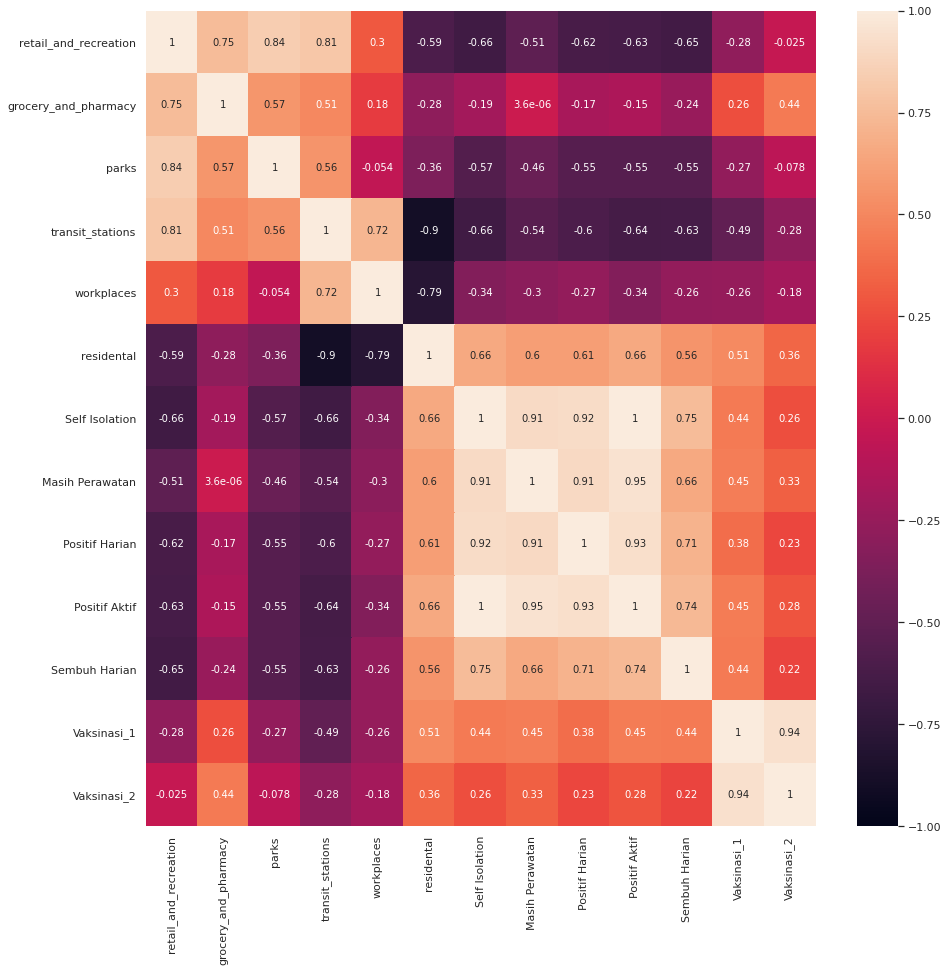

In [363]:
# correlation method
fig , ax = plt.subplots(figsize=(15,15))
sns.set(rc={'figure.figsize': (12,8)})
sns.heatmap(data_jakarta.corr(),annot = True, vmin=-1, vmax=1 ,annot_kws={'size': 10})

In [364]:
# RFE 
df_predictors = data_jakarta.drop(['Positif Harian', 'Sembuh Harian'], axis=1)


In [365]:
X_rfe = df_predictors.select_dtypes(exclude=['object'])
y_rfe = data_jakarta['Positif Harian']

In [366]:
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)

In [367]:
rfe.fit(X_rfe, y_rfe)

RFE(estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                     criterion='gini', max_depth=None,
                                     max_features=None, max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     presort='deprecated', random_state=None,
                                     splitter='best'),
    n_features_to_select=5, step=1, verbose=0)

In [368]:
for i in range(X_rfe.shape[1]):
    print('Column: %s, Selected=%s, Rank: %d' % (X_rfe.columns[i], rfe.support_[i], rfe.ranking_[i]))

Column: retail_and_recreation, Selected=True, Rank: 1
Column: grocery_and_pharmacy, Selected=True, Rank: 1
Column: parks, Selected=False, Rank: 3
Column: transit_stations, Selected=False, Rank: 5
Column: workplaces, Selected=True, Rank: 1
Column: residental, Selected=False, Rank: 7
Column: Self Isolation, Selected=True, Rank: 1
Column: Masih Perawatan, Selected=False, Rank: 2
Column: Positif Aktif, Selected=True, Rank: 1
Column: Vaksinasi_1, Selected=False, Rank: 4
Column: Vaksinasi_2, Selected=False, Rank: 6


Berkorelasi dengan Positif Harian :
- retail_and_recreation
- parks
- transit_stations
- workplaces
- Self Isolation
- Masih Perawatan


In [369]:
df = data_jakarta[['retail_and_recreation',
                  'parks',
                  'transit_stations',
                  'workplaces',
                  'Self Isolation',
                  'Masih Perawatan',
                  'Positif Harian']]

In [370]:
positif_harian_df = df.loc[df.index >= '2021-01-08']['Positif Harian'].values

In [371]:
df.shape

(229, 7)

#####Positif Harian

In [372]:
trace1 = go.Scatter(
                    x = data_jakarta.index,
                    y = data_jakarta["Positif Harian"],
                    mode = "lines",
                    name = "Positif Harian",
                    marker = dict(color = 'red'),
)
trace2 = go.Scatter(
                    x = data_jakarta.index,
                    y = data_jakarta["Self Isolation"],
                    mode = "lines",
                    name = "Self Isolation",
                    marker = dict(color = 'orange'),
)
trace3 = go.Scatter(
                    x = data_jakarta.index,
                    y = data_jakarta["Masih Perawatan"],
                    mode = "lines",
                    name = "Masih Perawatan",
                    marker = dict(color = 'grey'),
)
data = [trace1,trace2,trace3]
layout = dict(title = 'Positif Harian vs Self Isolation',
              xaxis = dict(title='Tanggal')
              )
fig = dict(data = data, layout = layout)
iplot(fig)

In [373]:
trace1 = go.Scatter(
                    x = data_jakarta.index,
                    y = data_jakarta['Positif Harian'],
                    mode = "lines",
                    name = "Positif Harian",
                    marker = dict(color = 'red'),
)
trace2 = go.Scatter(
                    x = data_jakarta.index,
                    y = data_jakarta["workplaces"]*150,
                    mode = "lines",
                    name = "retail_and_recreation",
                    marker = dict(color = 'orange'),
)
trace3 = go.Scatter(
                    x = data_jakarta.index,
                    y = data_jakarta["parks"]*150,
                    mode = "lines",
                    name = "parks",
                    marker = dict(color = 'green'),
)
trace4 = go.Scatter(
                    x = data_jakarta.index,
                    y = data_jakarta["transit_stations"]*150, 
                    mode = "lines",
                    name = "transit_stations",
                    marker = dict(color = 'blue'),
)
trace5 = go.Scatter(
                    x = data_jakarta.index,
                    y = data_jakarta["retail_and_recreation"]*150, 
                    mode = "lines",
                    name = "transit_stations",
                    marker = dict(color = 'gray'),
)

data = [trace1,trace2,trace3,trace4,trace5]
layout = dict(title = 'Positif Harian vs retail_and_recreation & parks & transit_stations & workplaces (scaled x150)',
              xaxis = dict(title='Tanggal')
              )
fig = dict(data = data, layout = layout)
iplot(fig)

##### Lag Plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


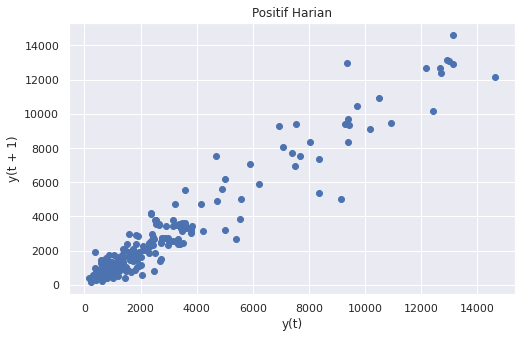

In [374]:
from pandas.plotting import lag_plot
plt.figure(figsize=(8,5))
lag_plot(data_jakarta['Positif Harian'])
plt.title("Positif Harian")
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


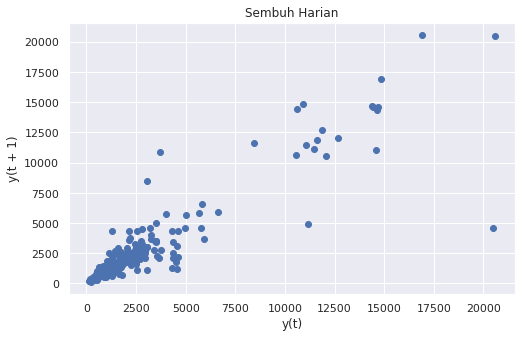

In [375]:
plt.figure(figsize=(8,5))
lag_plot(data_jakarta['Sembuh Harian'])
plt.title("Sembuh Harian")
plt.show()

### <h4> Feature Scaling

In [376]:
# data = dataframe after supervised
def Feature_scaling(data):
  scaler = MinMaxScaler()
  X_scaled = pd.DataFrame(scaler.fit_transform(data))
  X_scaled.columns = data.columns.values
  return X_scaled

### <h4> Feature Engineering

In [377]:
# transform time-series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)

	return agg

In [378]:
# input df_supervised, output Xtrain, Xtest, ytrain, ytest
def train_test_split_var(data, n_test, n_in):
  # for y
  y = np.asarray([[x] for x in data[:,-1]])
  y_shift = y[n_in:,:]
  ytrain, ytest = y[:-n_test, :],y[-n_test:, :]

  # for x
  X_supervised = np.asarray([ x for x in data[:,:-1]])
  # turn to dataframe for scaling
  df_X_supervised = pd.DataFrame(X_supervised)
  # Scaling
  X_scaled = Feature_scaling(df_X_supervised)
  # turn back to array
  X_supervised_scaled = np.asarray(X_scaled)
  X = np.asarray([x for x in data[:,:-1]])
  Xtrain, Xtest = X[:-n_test, :],X[-n_test:, :]

  return Xtrain, Xtest, ytrain, ytest

In [379]:
# label data H-7, H-6, H-5, ..., H
n_in = 7
df_supervised = series_to_supervised(df.values, n_in)
df_supervised = df_supervised.values

# <h2> Modelling </h2>

## <h3>Modeling Function

In [380]:
# walk-forward validation for multivariate data
def walk_forward_validation(data, n_test, n_in,params={}):
  predictions = list()
	# split dataset|
  Xtrain, Xtest, ytrain, ytest = train_test_split_var(data, n_test, n_in)
	# seed history with training dataset
  history = np.column_stack((Xtrain,ytrain))
  test = np.column_stack((Xtest,ytest))
	# step over each time-step in the test set
  for i in range(len(Xtest)):
		# split test row into input and output columns
    # testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
    yhat = xgboost_forecast(Xtrain,ytrain, Xtest[i],params)
		# store forecast in list of predictions
    predictions.append(yhat)
		# add actual observation to history for the next loop
    history = np.row_stack((history,test[i]))
    # summarize progress
    # print(ytest[i])
    # print(yhat)
    print('>expected=%.1f, predicted=%.1f' % (ytest[i], yhat))
	# estimate prediction error
  error = mean_absolute_error(test[:, -1],predictions)
  return error, test[:, -1], predictions

In [381]:
def xgboost_forecast(Xtrain, ytrain, Xtest,params):
	# fit model
	model = xgb.XGBRegressor(objective='reg:squarederror',**params)
	model.fit(Xtrain, ytrain)
	# make a one-step prediction
	yhat = model.predict([np.asarray(Xtest)])
	return yhat[0]

## <h3>Evaluate

In [382]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [383]:
params_initial = {'n_estimators':100}

In [384]:
df.drop('Positif Harian', axis= 1, inplace=True)
df_supervised = series_to_supervised(df.values, n_in)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [385]:
df_supervised['Positif Harian'] = positif_harian_df
df_supervised = df_supervised.values

In [386]:
Xtrain, Xtest, ytrain, ytest = train_test_split_var(df_supervised, n_test, n_in)

In [387]:
# evaluate
n_test = 20
mae, y, yhat = walk_forward_validation(df_supervised, n_test, n_in ,params_initial)
print('MAE: %.3f' % mae)

>expected=3845.0, predicted=3789.7
>expected=3454.0, predicted=3036.3
>expected=3327.0, predicted=3018.0
>expected=2701.0, predicted=3080.1
>expected=1410.0, predicted=2265.1
>expected=1601.0, predicted=1891.6
>expected=2981.0, predicted=2045.0
>expected=2311.0, predicted=2407.3
>expected=2185.0, predicted=2268.0
>expected=2008.0, predicted=1678.5
>expected=1649.0, predicted=2379.5
>expected=727.0, predicted=2280.1
>expected=1425.0, predicted=1959.3
>expected=1958.0, predicted=2166.6
>expected=1078.0, predicted=1728.5
>expected=1210.0, predicted=1622.6
>expected=1363.0, predicted=1801.8
>expected=1182.0, predicted=1959.0
>expected=513.0, predicted=1670.4
>expected=655.0, predicted=1139.4
MAE: 534.940


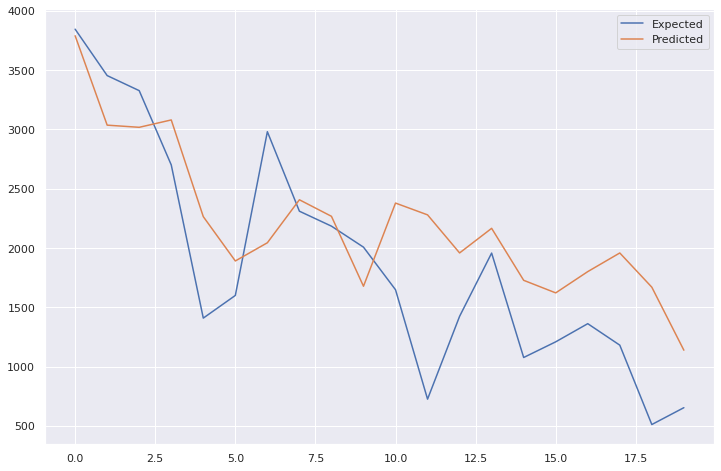

In [388]:
# plot expected vs preducted
plt.figure(figsize=(12,8))
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

In [389]:
run_testing(df_supervised,n_test,params_initial)

78.18806465130217

# <h2> Hyperparameter Tuning (Grid Search)

In [390]:
def run_modeling(data,n_test,params={}):
  Xtrain, Xtest, ytrain, ytest = train_test_split_var(data, n_test, n_in)
  X = np.row_stack((Xtrain,Xtest))
  y = np.row_stack((ytrain,ytest))
  model = xgb.XGBRegressor(objective='reg:squarederror',**params)
  return np.mean(cross_val_score(model, X, y, cv=5))

def run_testing(data,n_test,params={}):
  Xtrain, Xtest, ytrain, ytest = train_test_split_var(data, n_test, n_in)
  model = xgb.XGBRegressor(objective='reg:squarederror',**params)
  model.fit(Xtrain, ytrain)
  ypred = model.predict(Xtest)
  return mean_absolute_percentage_error(ytest,ypred)

In [391]:
run_modeling(df_supervised,n_test,params_initial)

-0.03385641397904624

In [392]:
run_testing(df_supervised,n_test,params_initial)

78.18806465130217

In [393]:
random.seed(1)

In [394]:
# learning_rate_list = [i/15 for i in range(1, 15 )]
# max_depth_list = [i for i in range(3, 10)]

In [395]:
# results_dict = {}
# for learning_rate in learning_rate_list:
#     for max_depth in max_depth_list:
        
#         ###################################################################
#         # put your ml training code here
#         results = run_modeling(df_supervised,n_test,params={'learning_rate':learning_rate,'max_depth':max_depth})
#         ###################################################################

#         results_dict[(learning_rate,max_depth)] = {'score':results}

In [396]:
# df_results = pd.DataFrame(results_dict).T.reset_index()
# df_results.columns = ['learning_rate','max_depth','score']
# df_results.sort_values(['score'],ascending=False)

In [397]:
# n_estimators_list = [i for i in range(50,100,10)]

In [398]:
# results_dict = {}
# for n_estimators in n_estimators_list:
#     for max_depth in max_depth_list:
        
        ###################################################################
        # put your ml training code here
        # results = run_modeling(df_supervised,n_test,params={'learning_rate':0.2,'n_estimators':n_estimators,'max_depth':7})
        ###################################################################

        # results_dict[(n_estimators,max_depth)] = {'score':results}

In [399]:
# df_results = pd.DataFrame(results_dict).T.reset_index()
# df_results.columns = ['n_estimators','max_depth','score']
# df_results.sort_values(['score'],ascending=False)

In [400]:
# gamma_list = [i/15 for i in range(0, 10 )]
# alpha_list = [i for i in range(0, 10)]

In [401]:
# results_dict = {}
# for alpha in alpha_list:
#     for gamma in gamma_list:
        
#         ###################################################################
#         # put your ml training code here
#         results = run_modeling(df_supervised,n_test,params={'learning_rate':0.2,'n_estimators':50,'max_depth':7,'alpha':alpha,'gamma':gamma})
#         ###################################################################

#         results_dict[(alpha,gamma)] = {'score':results}

In [402]:
# df_results = pd.DataFrame(results_dict).T.reset_index()
# df_results.columns = ['alpha','gamma','score']
# df_results.sort_values(['score'],ascending=False)

In [403]:
# eta_list = [i/100+0.01 for i in range(1,19)]
# min_child_weight_list  = [i for i in range(1, 10)]

In [404]:
# results_dict = {}
# for eta in eta_list:
#     for min_child_weight in min_child_weight_list:
        
#         ###################################################################
#         # put your ml training code here
#         results = run_modeling(df_supervised,n_test,params={'learning_rate':0.2,'n_estimators':50,'max_depth':7,'alpha':5,'gamma':0.33,'alpha':5,'min_child_weight':min_child_weight})
#         ###################################################################

#         results_dict[(eta,min_child_weight)] = {'score':results}

In [405]:
# df_results = pd.DataFrame(results_dict).T.reset_index()
# df_results.columns = ['eta','min_child_weight','score']
# df_results.sort_values(['score'],ascending=False)

In [406]:
final_params = {'learning_rate':0.15,
                'max_depth ':5,
                'gamma':0,
                'alpha':3,
                'n_estimators':20,
                'eta':0.02,
                'min_child_weight':1}
# final_params = {'learning_rate':0.2,
#                 'max_depth ':7,
#                 'gamma':0.33,
#                 'alpha':5,
#                 'n_estimators':50,
#                 'eta':0.02,
#                 'min_child_weight':1}

## <h3> Final Parameter Testing

In [407]:
mae, y, yhat = walk_forward_validation(df_supervised, n_test, n_in,final_params)
print('MAE: %.3f' % mae)

>expected=3845.0, predicted=3533.1
>expected=3454.0, predicted=2658.9
>expected=3327.0, predicted=2517.7
>expected=2701.0, predicted=2580.3
>expected=1410.0, predicted=2091.6
>expected=1601.0, predicted=1947.6
>expected=2981.0, predicted=1852.0
>expected=2311.0, predicted=2095.2
>expected=2185.0, predicted=1878.2
>expected=2008.0, predicted=1263.7
>expected=1649.0, predicted=1908.6
>expected=727.0, predicted=1921.4
>expected=1425.0, predicted=1910.0
>expected=1958.0, predicted=1866.8
>expected=1078.0, predicted=1350.9
>expected=1210.0, predicted=1432.3
>expected=1363.0, predicted=1482.2
>expected=1182.0, predicted=1482.2
>expected=513.0, predicted=1451.7
>expected=655.0, predicted=1265.6
MAE: 497.770


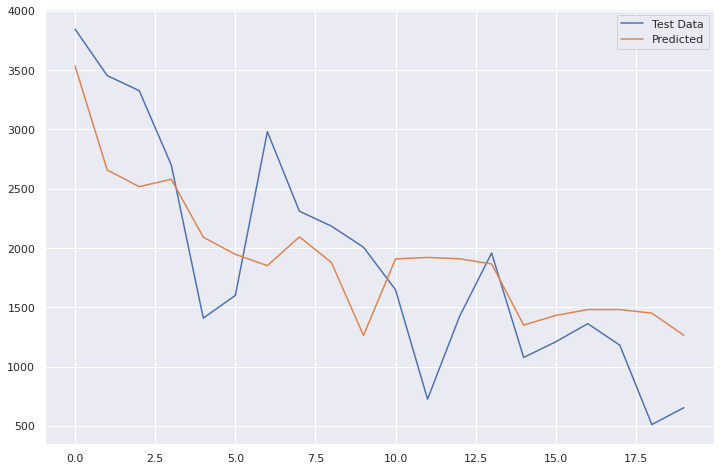

In [408]:
# plot expected vs preducted
plt.plot(y, label='Test Data')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

In [409]:
run_testing(df_supervised,n_test,final_params)

65.41298288072062

# Forecasting

In [410]:
data_prediksi_modelling = pd.read_csv('https://raw.githubusercontent.com/louis-not/Covid-19_Data_Analysis/master/Dataset/data_prediksi_modelling.csv', index_col = 'Tanggal')

In [411]:
data_prediksi_modelling.rename(columns = {'retail_and_recreation_percent_change_from_baseline': 'retail_and_recreation',
                                          'parks_percent_change_from_baseline': 'parks',
                                          'transit_stations_percent_change_from_baseline':'transit_stations',
                                          'workplaces_percent_change_from_baseline':'workplaces'}, inplace = True)

In [412]:
positif_harian_prediksi_df = data_prediksi_modelling.loc[data_prediksi_modelling.index >= '2021-08-18']['Positif Harian']

In [413]:
data_prediksi_modelling.drop('Positif Harian', axis= 1, inplace=True)

In [414]:
df_prediksi_supervised = series_to_supervised(data_prediksi_modelling.values, n_in)

In [419]:
  X_prediksi_supervised = np.asarray([ x for x in df_prediksi_supervised.values[:,:]])
  # turn to dataframe for scaling
  df_X_prediksi_supervised = pd.DataFrame(X_prediksi_supervised)
  # turn back to array
  X_prediksi_supervised = np.asarray(X_prediksi_supervised)

In [420]:
prediksi_modelling = []
for i in range(12):
  yhat = xgboost_forecast(Xtrain, ytrain,X_prediksi_supervised[i], final_params)
  prediksi_modelling.append(yhat)

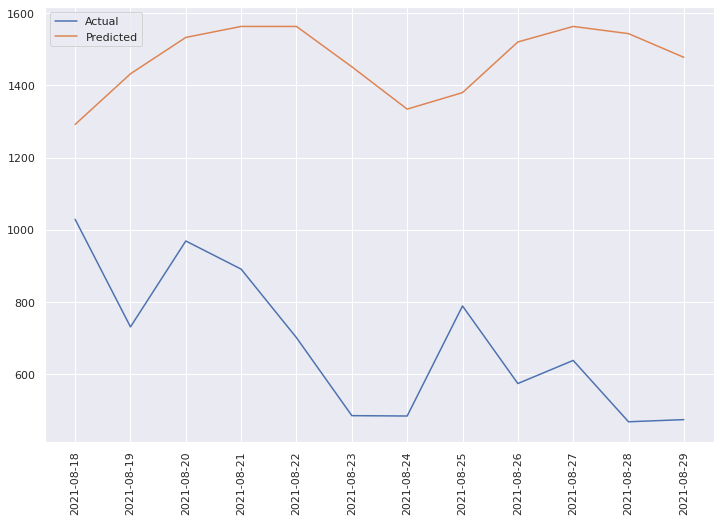

In [421]:
plt.plot(positif_harian_prediksi_df, label='Actual')
plt.plot(prediksi_modelling, label='Predicted')
plt.xticks(rotation = 90)
plt.legend()
plt.show()